# Run validation of LLM-judge evaluation

## Imports

In [1]:
import pandas as pd
import shutil
import aisuite as ai
from pathlib import Path
from textentlib.utils import read_configuration
from textentlib.llm_utils import fetch_prompts, try_extract_json_from_text
from textentlib.llm_utils import prepare_evaluation_dataframe, query_llm, query_llm_judge

## Read configuration

In [2]:
config = read_configuration(Path('../data/config.yaml'))
llms = config['validation']['models']
base_path = Path('/Users/mromanel/Documents/UniGe-TextEnt/chrono-spatial-processing/')
gt_path = base_path / config['validation']['groundtruth_path']
pregen_prompts_path = base_path / config['validation']['pregenerated_prompts_path']

In [3]:
print('\n'.join(llms))

ollama:phi4-mini:latest
ollama:gemma3:12b
ollama:mistral-small:24b
ollama:deepseek-r1:14b
ollama:deepseek-r1:32b
openai:o1-mini
openai:gpt-4o
deepseek:deepseek-reasoner
anthropic:claude-3-7-sonnet-20250219


## Get LLM predictions on validation documents

In [24]:
validation_llm_responses_path = Path(base_path / config['validation']['responses_path'])

In [25]:
# this should return only the test (validation) set (n=5 docs)
validation_docs, df_validation_data = prepare_evaluation_dataframe(
    llm_response_path=validation_llm_responses_path,
    gt_annotations_path=gt_path,
    gt_metadata_path=gt_path,
    split="test"
)

"['Unnamed: 11', 'Unnamed: 12'] not found in axis"


In [26]:
df_validation_data.to_csv('../data/evaluation_data.tsv', sep='\t')

In [7]:
validation_docs = ['bpt6k10901623',
 'bpt6k9807756q',
 'bpt6k852913n',
 'bpt6k5772699f',
 'bpt6k1090242p']

In [8]:
llm_requests = fetch_prompts(Path(pregen_prompts_path), validation_docs)

In [9]:
len(llm_requests)

15

In [10]:
llm_requests

[LLMrequest(prompt_id='prompt-excerpt.txt', document_id='bpt6k10901623', prompt_path=PosixPath('/Users/mromanel/Documents/UniGe-TextEnt/chrono-spatial-processing/data/prompts/pregenerated/bpt6k10901623/bpt6k10901623_prompt-excerpt.txt'), prompt='Look at the following JSON object describing a theatre play in French (XVII century); the `metadata` property contains basic information about the play (author, title, publication date), while the `excerpt` property contains an excerpt of 400 words sampled from around the middle of the document.\n\nINPUT:\n```json\n{\n  "metadata": {\n    "author": "Boisrobert, François de",\n    "title": "Théodore, Reyne de Hongrie, tragi-comédie",\n    "publication_date": "1658",\n    "document_id": "bpt6k10901623"\n  },\n  "excerpt": "re; Oui j\'ai pitié de vous, Prince, et je vous promets, Si vous vous repentez, de n\'y penser jamais, Je me reprocherai cette ardeur enragée, Comme si on l\'avais bizarrement songée, Revenez donc à vous, ouvrez, ouurez les yeu

In [11]:
validation_llm_responses_path

PosixPath('/Users/mromanel/Documents/UniGe-TextEnt/chrono-spatial-processing/data/validation/llm_responses')

In [ ]:
# Clean up the LLM responses before generating new ones 
def clean_up_directory(directory_path: Path) -> None:
    for item in directory_path.iterdir():
        if item.is_dir():
            print(f'Removed folder {item} and all its contents')
            shutil.rmtree(item)
        else:
            print(f'Removed file {item}')
            item.unlink()

In [ ]:
#clean_up_directory(validation_llm_responses_path)

In [14]:
client = ai.Client()
client.configure({"ollama" : {"timeout": 600}})

In [15]:
llms

['ollama:phi4-mini:latest',
 'ollama:gemma3:12b',
 'ollama:mistral-small:24b',
 'ollama:deepseek-r1:14b',
 'ollama:deepseek-r1:32b',
 'openai:o1-mini',
 'openai:gpt-4o',
 'deepseek:deepseek-reasoner',
 'anthropic:claude-3-7-sonnet-20250219']

In [19]:
llm_responses = []
reasoning_llms = ['openai:o1-mini', 'deepseek:deepseek-reasoner', 'anthropic:claude-3-7-sonnet-20250219']
default_temperature = config['validation']['temperature']

for model in llms:
    if model.startswith('ollama'):
        print(f'Skipping {model}')
        continue
    if model in reasoning_llms:
        llm_responses += query_llm(client, model, llm_requests, validation_llm_responses_path)
    else:
        llm_responses += query_llm(client, model, llm_requests, validation_llm_responses_path, temperature=default_temperature)

Skipping ollama:phi4-mini:latest
Skipping ollama:gemma3:12b
Skipping ollama:mistral-small:24b
Skipping ollama:deepseek-r1:14b
Skipping ollama:deepseek-r1:32b
Processing prompt prompt-excerpt.txt for document bpt6k10901623 using model openai:o1-mini (temp=None)
Time taken to get response: 7.35 seconds. Total tokens: 1427
Processing prompt prompt-metadata.txt for document bpt6k10901623 using model openai:o1-mini (temp=None)
Time taken to get response: 7.43 seconds. Total tokens: 1278
Processing prompt prompt-summary.txt for document bpt6k10901623 using model openai:o1-mini (temp=None)
Time taken to get response: 7.94 seconds. Total tokens: 2290
Processing prompt prompt-excerpt.txt for document bpt6k1090242p using model openai:o1-mini (temp=None)
Time taken to get response: 9.95 seconds. Total tokens: 2094
Processing prompt prompt-metadata.txt for document bpt6k1090242p using model openai:o1-mini (temp=None)
Time taken to get response: 9.10 seconds. Total tokens: 1236
Processing prompt pr

## Prepare data for scoring

## Ask LLM-judge

- get list of LLM judges (from config file)
- for each model, get score predictions and save to a dataframe/csv file (`data/validation/scores`)
    - save both the predictions (scores + reasons) and the unpacked scores (for further processing) 

In [4]:
validation_llm_responses_path = Path(base_path / config['validation']['responses_path'])

In [5]:
# this should return only the test (validation) set (n=5 docs)
validation_docs, df_validation_data = prepare_evaluation_dataframe(
    llm_response_path=validation_llm_responses_path,
    gt_annotations_path=gt_path,
    gt_metadata_path=gt_path,
    split="test"
)

"['Unnamed: 11', 'Unnamed: 12'] not found in axis"


In [6]:
df_validation_data.head(3)

,prompt_id,model_name,document_id,author,title,publication_date,document_length,keep_fine_tuning,gt_period,pred_period,...,gt_preferred_location,gt_accepted_locations,pred_location,score_location_string,gt_preferred_location_QID,gt_acceptable_location_QIDs,pred_location_qid,score_location_qid,gt_location_reason,pred_location_reasoning
response_id,,,,,,,,,,,,,,,,,,,,,
bpt6k10901623$prompt-excerpt.txt$ollama:mistral-small:24b,prompt-excerpt.txt,ollama:mistral-small:24b,bpt6k10901623,"Boisrobert, François de","Théodore, Reyne de Hongrie, tragi-comédie",1658,80779,True,Middle Ages,Middle Ages,...,Székesfehérvár,Székesfehérvár | Albe royale | Alba Regia | Hu...,Hungary,None,Q130212,Q130212 | Q28,Q27,None,- name of the town: Albe royale - King and que...,"The title explicitly mentions 'Hongrie', which..."
bpt6k10901623$prompt-summary.txt$openai:o1-mini,prompt-summary.txt,openai:o1-mini,bpt6k10901623,"Boisrobert, François de","Théodore, Reyne de Hongrie, tragi-comédie",1658,80779,True,Middle Ages,None,...,Székesfehérvár,Székesfehérvár | Albe royale | Alba Regia | Hu...,Hungary,None,Q130212,Q130212 | Q28,Q28,None,- name of the town: Albe royale - King and que...,The title of the play refers to 'Reyne de Hong...
bpt6k10901623$prompt-metadata.txt$openai:gpt-4o,prompt-metadata.txt,openai:gpt-4o,bpt6k10901623,"Boisrobert, François de","Théodore, Reyne de Hongrie, tragi-comédie",1658,80779,True,Middle Ages,Middle Ages,...,Székesfehérvár,Székesfehérvár | Albe royale | Alba Regia | Hu...,Kingdom of Hungary,None,Q130212,Q130212 | Q28,Q28,None,- name of the town: Albe royale - King and que...,The title explicitly mentions 'Reyne de Hongri...


In [7]:
from typing import List
from textentlib.prompting import build_llm_judge_prompt

def add_prompt(row) -> str:
    """
    Builds a prompt for the LLM judge task based on the row data.
    """

    prediction_columns = [col for col in df_validation_data.columns if col.startswith('pred_') and not col.endswith('reasoning')]
    reference_columns = [col for col in df_validation_data.columns if col.startswith('gt_') and not col.endswith('reason')]

    prediction_dict = row[prediction_columns].to_dict()
    reference_dict = row[reference_columns].to_dict()

    #print(reference_dict, prediction_dict)

    prompt = build_llm_judge_prompt(
        prediction=prediction_dict,
        reference=reference_dict,
        prompts_base_path=Path('../data/prompts/'))
    return prompt

def process_llm_judge_responses(llm_judge_responses) -> List[dict]:
    scores  = []
    for r in llm_judge_responses:
        _, scores_dict = try_extract_json_from_text(r.response)
        scores_dict['response_id'] = r.document_id
        scores_dict['evaluator'] = r.model_name
        scores_dict['total_tokens'] = r.total_tokens
        scores.append(scores_dict)
    return scores

In [8]:
df_validation_data['llm_judge_prompt'] = df_validation_data.apply(add_prompt, axis=1)

In [9]:
from textentlib.llm_utils import LLMrequest, query_llm_judge, try_extract_json_from_text

llm_judge_requests =[
    LLMrequest(
        prompt_id='llm_judge_prompt',
        document_id=response_id,
        prompt_path=None,
        prompt=item['llm_judge_prompt']
    )
    for response_id, item in df_validation_data[['llm_judge_prompt']].to_dict(orient='index').items()
]

In [10]:
len(llm_judge_requests)

135

In [11]:
client = ai.Client()
client.configure({
  "ollama" : {
    "timeout": 600,
  }
})

In [14]:
llm_judges = config['llm-judge']['models']

In [16]:
llm_judges

['ollama:phi4-mini:latest',
 'ollama:mistral-small:24b',
 'openai:o1-mini',
 'deepseek:deepseek-reasoner',
 'anthropic:claude-3-7-sonnet-20250219']

In [ ]:
# Query LLMs and collect responses
reasoning_llms = ['openai:o1-mini', 'deepseek:deepseek-reasoner', 'anthropic:claude-3-7-sonnet-20250219']
default_temperature = config['llm-judge']['temperature']
scores_output_path = Path(config['llm-judge']['scores_output_path'])

for model in llm_judges:
    # ask only LLMs with an API
    if model.startswith('ollama') or model == "openai:o1-mini":
        print(f'Skipping {model}')
        continue

    # Query the candidate judge LLMs
    llm_judge_responses = []
    print('Running predictions for model:', model)
    if model in reasoning_llms:
        llm_judge_responses += query_llm_judge(client, model, llm_judge_requests)
    else:
        llm_judge_responses += query_llm_judge(client, model, llm_judge_requests, temperature=default_temperature)
    
    # Stores produced socres in a TSV file
    scores  = process_llm_judge_responses(llm_judge_responses)
    scores_tsv_path = base_path / scores_output_path / f"{model}_scores.tsv"
    pd.DataFrame(scores).to_csv(f"{scores_tsv_path}", sep='\t')
    

Skipping ollama:phi4-mini:latest
Skipping ollama:mistral-small:24b
Skipping openai:o1-mini
Running predictions for model: deepseek:deepseek-reasoner
Processing prompt llm_judge_prompt for document bpt6k10901623$prompt-excerpt.txt$ollama:mistral-small:24b using model deepseek:deepseek-reasoner
Processing prompt llm_judge_prompt for document bpt6k10901623$prompt-summary.txt$openai:o1-mini using model deepseek:deepseek-reasoner
Processing prompt llm_judge_prompt for document bpt6k10901623$prompt-metadata.txt$openai:gpt-4o using model deepseek:deepseek-reasoner
Processing prompt llm_judge_prompt for document bpt6k10901623$prompt-metadata.txt$deepseek:deepseek-reasoner using model deepseek:deepseek-reasoner
Processing prompt llm_judge_prompt for document bpt6k10901623$prompt-summary.txt$ollama:phi4-mini:latest using model deepseek:deepseek-reasoner
Processing prompt llm_judge_prompt for document bpt6k10901623$prompt-metadata.txt$anthropic:claude-3-7-sonnet-20250219 using model deepseek:deep

## Compute IAA between scorers

- read in all the scores on the validation docs (human + LLM-judge)
- reshape dataframe so to have for each document and for each score type, all the scores assigned
- for each score type compute the IAA
- compute an average IAA across all score types

## Other statistics

In [4]:
import matplotlib
from textentlib.llm_utils import process_llm_responses

In [80]:
df = process_llm_responses(base_path / Path(config['validation']['responses_path']))

In [81]:
df.head(2)

,response_path,document_id,prompt_id,model_name,response,duration_seconds,prompt_tokens,completion_tokens,total_tokens,is_response_valid_json,is_valid_json_recovered,period,period_reasoning,timeframe_start,timeframe_end,location,location_reasoning,location_qid
0,/Users/mromanel/Documents/UniGe-TextEnt/chrono...,bpt6k10901623,prompt-excerpt.txt,ollama:mistral-small:24b,"{\n ""period"": ""Middle Ages"",\n ""period_reaso...",36.471903,NaN,NaN,NaN,True,False,Middle Ages,"The title of the play, 'Théodore, Reyne de Hon...",-1000,+1500,Hungary,"The title explicitly mentions 'Hongrie', which...",Q27
1,/Users/mromanel/Documents/UniGe-TextEnt/chrono...,bpt6k10901623,prompt-summary.txt,openai:o1-mini,"{\n ""period"": null,\n ""period_reasoning""...",7.939035,1149.0,1141.0,2290.0,True,False,None,The provided information does not specify a hi...,None,None,Hungary,The title of the play refers to 'Reyne de Hong...,Q28


In [82]:
df_benchmark_speed = pd.pivot_table(
    values='duration_seconds',
    columns='model_name',
    data=df, aggfunc='mean'
).T

In [83]:
df_avg_tokens = pd.pivot_table(
    values=['prompt_tokens', 'completion_tokens'],
    columns='model_name',
    data=df, aggfunc='mean'
).T.rename(columns={'completion_tokens': 'output_tokens', 'prompt_tokens': 'input_tokens'})

In [84]:
df_avg_tokens

,output_tokens,input_tokens
model_name,,
anthropic:claude-3-7-sonnet-20250219,252.733333,918.933333
deepseek:deepseek-reasoner,1109.733333,805.733333
openai:gpt-4o,158.533333,775.133333
openai:o1-mini,888.066667,795.133333


In [85]:
cost_per_token = [
    {
        'model_name': model,
        'cost_per_1M_tokens_input': None,
        'cost_per_1M_tokens_output': None
    }
    for model in df_benchmark_speed.index.to_list()
]

In [86]:
# all costs expressed in USD

cost_per_hour_baobab = 0.11 # 0.10 CHF = 0.11 USD

cost_per_token = [
    {
        'model_name': 'anthropic:claude-3-7-sonnet-20250219',
        'cost_per_hour': None,
        'cost_per_1M_tokens_input': 3.0,
        'cost_per_1M_tokens_output': 15.0
    },
    {
        'model_name': 'deepseek:deepseek-reasoner',
        'cost_per_hour': None,
        'cost_per_1M_tokens_input': 0.55, # considering 'cache miss' cost
        'cost_per_1M_tokens_output': 2.19
    },
    {
        'model_name': 'ollama:deepseek-r1:14b', 
        'cost_per_hour': cost_per_hour_baobab,
        'cost_per_1M_tokens_input': None,
        'cost_per_1M_tokens_output': None
    },
    {
        'model_name': 'ollama:deepseek-r1:32b',
        'cost_per_hour': cost_per_hour_baobab,
        'cost_per_1M_tokens_input': None,
        'cost_per_1M_tokens_output': None
    },
    {
        'model_name': 'ollama:gemma3:12b',
        'cost_per_hour': cost_per_hour_baobab,
        'cost_per_1M_tokens_input': None,
        'cost_per_1M_tokens_output': None
    },
    {
        'model_name': 'ollama:mistral-small:24b',
        'cost_per_hour': cost_per_hour_baobab,
        'cost_per_1M_tokens_input': None,
        'cost_per_1M_tokens_output': None
    },
    {
        'model_name': 'ollama:phi4-mini:latest',
        'cost_per_hour': cost_per_hour_baobab,
        'cost_per_1M_tokens_input': None,
        'cost_per_1M_tokens_output': None
    },
    {
        'model_name': 'openai:gpt-4o',
        'cost_per_hour': None,
        'cost_per_1M_tokens_input': 2.5,
        'cost_per_1M_tokens_output': 10.0
    },
    {
        'model_name': 'openai:o1-mini',
        'cost_per_hour': None,
        'cost_per_1M_tokens_input': 1.10,
        'cost_per_1M_tokens_output': 4.40
    }
]

In [87]:
df_benchmark_speed

,duration_seconds
model_name,
anthropic:claude-3-7-sonnet-20250219,5.202731
deepseek:deepseek-reasoner,63.381709
ollama:deepseek-r1:14b,69.133920
ollama:deepseek-r1:32b,156.856872
ollama:gemma3:12b,14.933889
ollama:mistral-small:24b,31.787582
ollama:phi4-mini:latest,11.554595
openai:gpt-4o,3.889093
openai:o1-mini,6.988482


In [88]:
df_benchmark = df_benchmark_speed.join(df_avg_tokens).join(pd.DataFrame(cost_per_token).set_index('model_name'))

In [89]:
df_benchmark.head(3)

,duration_seconds,output_tokens,input_tokens,cost_per_hour,cost_per_1M_tokens_input,cost_per_1M_tokens_output
model_name,,,,,,
anthropic:claude-3-7-sonnet-20250219,5.202731,252.733333,918.933333,NaN,3.00,15.00
deepseek:deepseek-reasoner,63.381709,1109.733333,805.733333,NaN,0.55,2.19
ollama:deepseek-r1:14b,69.133920,NaN,NaN,0.11,NaN,NaN


In [90]:
def calculate_cost(row):
    """
    Calculate cost per 1k document, based on avg. number of input and output tokens,
    as calculated by each API.
    """
    if pd.isnull(row['cost_per_hour']):
        cost_per_input_token = row['cost_per_1M_tokens_input'] / 1_000_000
        cost_input = row['input_tokens'] * cost_per_input_token
        cost_per_output_token = row['cost_per_1M_tokens_output'] / 1_000_000
        cost_output = row['output_tokens'] * cost_per_output_token
        total_cost = cost_input + cost_output
        return total_cost * 1_000
    else:
        total_cost = row['duration_seconds'] * (row['cost_per_hour'] / 3600)
        return total_cost * 1_000
     

In [91]:
def calculate_time(row):
    return (row['duration_seconds'] * 1_000) / 3600

In [92]:
df_benchmark['usd_per_1k_document'] = df_benchmark.apply(
    lambda row: calculate_cost(row),
    axis=1
)

In [93]:
df_benchmark['hours_per_1k_document'] = df_benchmark.apply(
    lambda row: calculate_time(row),
    axis=1
)

In [94]:
df_benchmark[['duration_seconds', 'input_tokens', 'output_tokens', 'usd_per_1k_document', 'hours_per_1k_document']]

,duration_seconds,input_tokens,output_tokens,usd_per_1k_document,hours_per_1k_document
model_name,,,,,
anthropic:claude-3-7-sonnet-20250219,5.202731,918.933333,252.733333,6.547800,1.445203
deepseek:deepseek-reasoner,63.381709,805.733333,1109.733333,2.873469,17.606030
ollama:deepseek-r1:14b,69.133920,NaN,NaN,2.112425,19.203867
ollama:deepseek-r1:32b,156.856872,NaN,NaN,4.792849,43.571353
ollama:gemma3:12b,14.933889,NaN,NaN,0.456313,4.148302
ollama:mistral-small:24b,31.787582,NaN,NaN,0.971287,8.829884
ollama:phi4-mini:latest,11.554595,NaN,NaN,0.353057,3.209610
openai:gpt-4o,3.889093,775.133333,158.533333,3.523167,1.080304
openai:o1-mini,6.988482,795.133333,888.066667,4.782140,1.941245


<Axes: title={'center': 'Average LLM processing time (seconds) per document'}, ylabel='Large Language Model (LLM)'>

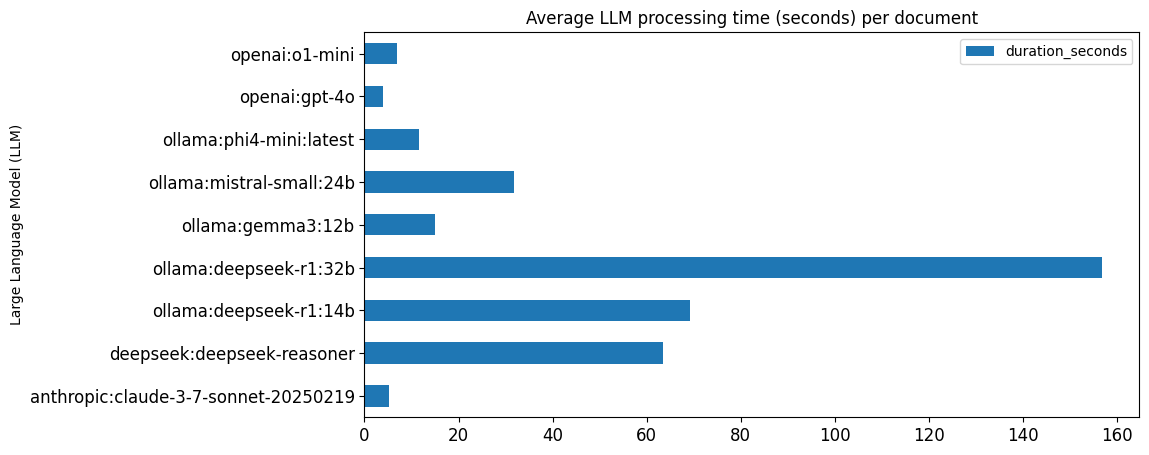

In [60]:
df_benchmark_speed.plot(
    kind='barh',
    figsize=(10, 5),
    title='Average LLM processing time (seconds) per document', 
    fontsize=12,
    ylabel='Large Language Model (LLM)',
)